# DCA Backtesting Tool

## Overview
This tool provides a comprehensive simulation of a Dollar-Cost Averaging (DCA) investment strategy, allowing for backtesting against historical stock data. Users can test strategies based on investing a fixed amount into the 'k' lowest-performing stocks over a defined lookback period. Features include adjustable lookback and investment cadence periods, and the ability to specify overweight/underweight investment allocations.

## Installation
The tool is designed to work with Anaconda's Python 3.x distribution for ease of use and installation:

1. Download the latest version of the code from [GitHub](https://github.com/nrego/dca_portfolio/).
2. From the root directory of the project, create and activate a custom Python Conda environment using the provided "environment.yaml" file:

```bash
conda env create -f environment.yaml
conda activate dca_portfolio
```

3. (Optional) Create a Jupyter Notebook kernel named "dca_portfolio":

```bash
python -m ipykernel install --user --name dca_portfolio --display-name "Python (dca_portfolio)"
```

## Usage
To use the DCA backtesting tool:

1. Launch Jupyter Notebook from the root directory:

```bash
jupyter notebook
```

2. Open the "dca_portfolio.ipynb" notebook and select the "Python (dca_portfolio)" kernel.
3. Run all cells in the notebook to initialize the tool.
4. At the bottom of the notebook, use the GUI to input your simulation parameters and run the simulation:

    - Upload a list of stock ticker symbols (plain text file, one ticker per line). Sample files can be found in "./sample_stocks/".
    - Enter your FMP API key (optional).
    - Specify the investment amount per period, number of stocks (`k`), loss threshold (in percent), overweight allocation (in percent), lookback period (in months), and investment period (in months).
    - Click "Run Simulation" to start the backtesting process. This might take a while as it downloads historical data and performs the simulation.

## Results Visualization
The tool provides two main tabs for results visualization:

- **Equity Graph**: Plots the simulated performance of your investment strategy over time, comparing it to a baseline strategy of equally investing in all stocks each period.
- **Cohorts and Strategy**: Displays a DataFrame illustrating the performance of each investment cohort over time, including the aggregate performance of all cohorts.
- **Download Results**: Allows you to download detailed results as Excel files, including the investment strategy performance and selection history.


## Example

Here's an example using the snp500.txt dataset, with a dollar investment per period of $100, where the 5 lowest returning stocks are chosen each month (num stocks is 5, lookback and investment periods are both 1 month). The blue curve illustrates the simulated performance using this DCA strategy, and the orange curve illustrates a null benchmark strategy, where 100 is invested equally into all of the stocks during each investment period.

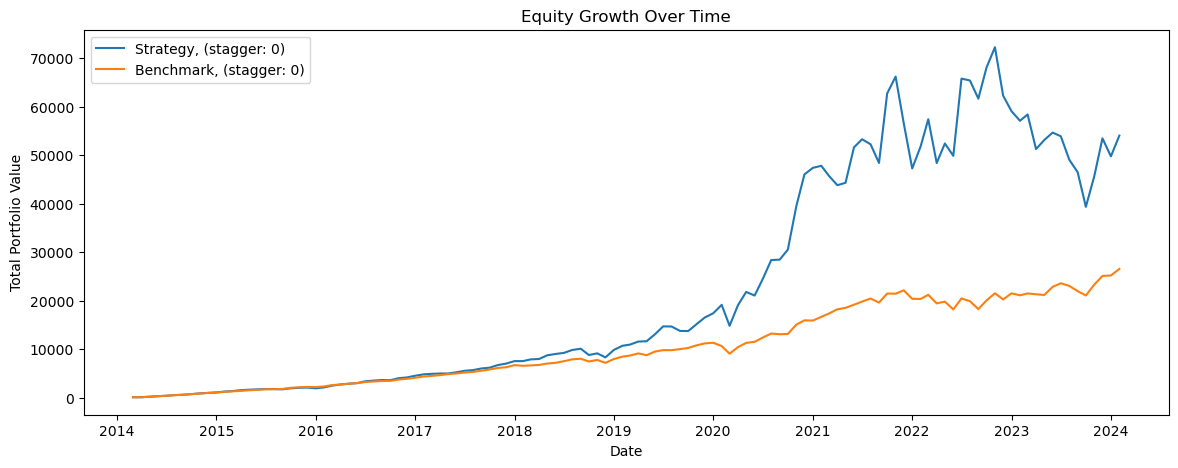


# Background and Formalism


$\newcommand{\price}[2]{p_{#1}^{(#2)}}$
$\newcommand{\return}[2]{r_{#1}^{(#2)}(\tau)}$
$\newcommand{\dollar}{d}$
$\newcommand{\lookback}{\tau}$
$\newcommand{\invperiod}{\delta}$
$\newcommand{\overweight}{\omega}$


Given:
- $\price{i}{t}$: the price of stock $i$ at period $t$.
- $i \in \{1, 2, \ldots, N\}$, where $N$ is the total number of stocks in the universe.
- $t \in \{0, 1, \ldots, m - 1\}$, where $t=0$ is the arbitrary start date, and $t$ goes up to $m-1$, where $m$ is the number of months in the dataset.
- $\dollar$: the dollar amount invested each investment period.
- $\return{i}{t}$: the return on stock $i$ over the lookback period $\lookback$, defined as $\return{i}{t} \equiv \frac{\price{i}{t} - \price{i}{t-\lookback}}{\price{i}{t-\lookback}}$ (for $t \geq \lookback$).
- $\lookback \in \{1, 2, \ldots, m-1\}$: the lookback period, in months, over which returns are calculated.
- $\invperiod \in \{1, 2, \ldots, m-1\}$: the investment frequency (cadence), in months.
- $\overweight$: the overweight allocation fraction, representing the portion of $\dollar$ invested in the selected stocks each period. ($0 \leq \overweight \leq 1$).

# Expanding on Cohorts and Value Calculation

Continuing from the previously defined symbols, we introduce:

- $\mathcal{C}_{t}$: the cohort formed at time $t$, consisting of selected stocks and their allocated shares.
- $\mathcal{S}_{t}^{o}$: the set of up to $k$ overweight stocks selected for cohort $\mathcal{C}_{t}$.
- $\mathcal{S}_{t}^{u}$: the set of underweight stocks, i.e., the remaining stocks in the universe not included in $\mathcal{S}_{t}^{o}$.
- $l_{t}$: the number of stocks in $\mathcal{S}_{t}^{o}$, where $0 \leq l_{t} \leq k$.
- $n_{i,t}$: the number of shares of stock $i$ included in cohort $\mathcal{C}_{t}$.
- $V(\mathcal{C}_{t}, t')$: the value of cohort $\mathcal{C}_{t}$ at a future time $t'$.

Algorithm outline:

1. Starting at $t=\lookback$ and at each subsequent period $t = \lookback + n\invperiod$ (where $n$ is a non-negative integer), perform the following steps:
   1. Select up to $k$ stocks that have the lowest returns $\return{i}{t}$ over the lookback period $\lookback$, optionally filtering to include only those with returns below a certain threshold.
   2. Allocate $\overweight \cdot \dollar$ evenly across the selected stocks, $\mathcal{S}_{t}^{o}$, and $(1-\overweight) \cdot \dollar$ evenly across the remaining stocks, $\mathcal{S}_{t}^{u}$.
   3. Define $\mathcal{C}_{t}$ to include $\mathcal{S}_{t}^{o}$ and $\mathcal{S}_{t}^{u}$, along with the corresponding shares $n_{i,t}$ for each stock based on the allocation.

2. The number of shares $n_{i,t}$ for each selected stock $i$ in $\mathcal{S}_{t}^{o}$ is given by $\frac{\overweight \cdot \dollar}{l_{t} \cdot \price{i}{t}}$ and for each underweight stock $j$ in $\mathcal{S}_{t}^{u}$ by $\frac{(1-\overweight) \cdot \dollar}{(N-l_{t}) \cdot \price{j}{t}}$. This is assuming $l_{t} > 0$; if $l_t = 0$, then $(1-\overweight)d$ is invested equally into all of the stocks of the universe.

3. The value of a cohort $\mathcal{C}_{t}$ at any future time $t'$, $V(\mathcal{C}_{t}, t')$, is calculated as $\sum_{i \in \mathcal{S}_{t}^{o}} n_{i,t} \cdot \price{i}{t'} + \sum_{j \in \mathcal{S}_{t}^{u}} n_{j,t} \cdot \price{j}{t'}$.

4. The aggregate value of all cohorts at any time $t'$ is the sum of $V(\mathcal{C}_{t}, t')$ for all cohorts formed up to and including $t'$.

## Improvements

1. Rigorous statistics. Currently, this codebase simulates a single "trial" DCA investment strategy and outputs the simulated $V(\mathcal{C}_{t}, t')$ versus $t'$. It would be nice to add some stats to this - in particular, estimate $\langle(V(\mathcal{C}_{t}, t'))\rangle$, the expected value (average) of the performance of this investment over time, as well as the standard errors of the mean returns. This can provide valuable volatility estimates, allowing the user to estimate the relative risk of a given DCA investment strategy.
2. Introduce adaptive allocation strategies - e.g. modify the selection criteria, dollar invested, etc, at each investment period by tracking past cohort's performance. This would still be a DCA strategy (past cohorts will remain unchanged), but the strategy will "learn", on the fly, ideal investment allocation strategies.
3. Systematic/automatic grid search over input parameter space to determine "ideal" investment strategies. This is slightly different than the above (though could be implemented independently). The "objective function" here is arbitray - it could be choosing parameters to maximize expected returns, minimize volatility, or a combination of both.



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from financetoolkit import Toolkit
from typing import List, Any
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import codecs
import base64
import csv
from io import StringIO

## DCA Backtesting Algorithm

In [2]:
def simulate(price, k=5, bet=100.0, period_invest=1, period_lookback=1, loss_threshold=np.inf, overweight_allocation=1.0):
    """
    Simulate investment strategy over a given price history.

    This function simulates a staggered investment strategy where investments are made
    in the bottom 'k' performing stocks based on their return over a 'period_lookback'.
    Investments are made every 'period_invest' month(s), and the function tracks the performance
    of each cohort of investments as well as the selection history.

    Parameters:
    - price: A pandas DataFrame with datetime index containing the price history of stocks.
             The DataFrame should have months as the frequency of the datetime index.
    - k: The number of stocks to invest in at each investment period. Defaults to 5.
    - bet: The amount of money to invest in each period across the selected stocks. Defaults to 100.0.
    - period_invest: The frequency of investment periods in months. Defaults to 1.
    - period_lookback: The lookback period in months to calculate returns for selecting stocks. Defaults to 1.
    - loss_threshold: A threshold for filtering stocks based on their return. Only stocks with a return
                      below this threshold are considered for investment. Defaults to infinity (np.inf), meaning
                      all stocks are considered.
    - overweight_allocation: (between 0 and 1) - fraction of bet that will be invested in the (up to) k stocks chosen at each step.
                      Remaining funds (1-overweight_allocation)*bet will be invested uniformly in the remaining stocks in the universe 

    Returns:
    - combined_cohorts: A list of DataFrames, each representing the combined investment performance of cohorts
                        for each stagger period. Each DataFrame contains the cumulative value of investments over time.
    - selection_histories: A list of DataFrames, each containing the history of stock selections made at each
                           investment period for each stagger. Each DataFrame's columns correspond to the ranks of stocks
                           selected, and rows correspond to investment periods.

    """

    # Ensure preconditions are met
    assert isinstance(price.index.freq, pd.offsets.MonthEnd), "ERROR: Expecting month end data...."
    
    n_months = len(price)
    last_month = n_months + 1 - 2 * period_invest
    n_cohorts = (n_months - period_lookback) // period_invest

    # Amount we'll invest into overweight (chosen) and underweight (not chosen) stocks each period_invest
    assert 0 <= overweight_allocation <= 1.0
    bet_over = overweight_allocation * bet
    bet_under = (1-overweight_allocation) * bet
    
    # Initialize empty lists to hold the combined cohorts and selection histories for each stagger
    combined_cohorts = []
    selection_histories = []
    
    # Initialize selection_history DataFrames
    for i_stagger in range(period_invest):
        selection_histories.append(pd.DataFrame(index=price.index, columns=range(1, k+1)))
    
    cohort_dict = [{} for _ in range(period_invest)]
    
    for idx in range(period_lookback, n_months - period_invest, period_invest):
        for i_stagger in range(period_invest):
            idx_curr = idx + i_stagger
            idx_prev = idx_curr - period_lookback
            
            p_0 = price.iloc[idx_prev]
            p_t = price.iloc[idx_curr]
            rtn = (p_t - p_0) / p_0

            # Up to k lowest return stocks selected
            selected_stocks = rtn[rtn < loss_threshold].nsmallest(k).index
            unselected_stocks = rtn.index.difference(selected_stocks)
            unselected_stocks = unselected_stocks[p_t[unselected_stocks] != 0.0]
            
            # Fill the selection history for the current period
            for j in range(k):
                if len(selected_stocks) > j:
                    selection_histories[i_stagger].iloc[idx_curr, j] = selected_stocks[j]
                else:
                    selection_histories[i_stagger].iloc[idx_curr, j] = '-'

            cohort_performance = pd.Series(0.0, index=price.index)
            
            if len(selected_stocks) > 0:
                
                n_shares = (bet_over / len(selected_stocks)) * (1 / p_t[selected_stocks])
                #sanity
                assert np.isclose(np.dot(n_shares, p_t[selected_stocks]), bet_over)
                
                for idx_end in range(idx_curr, n_months):
                    p_end = price.iloc[idx_end]
                    current_val = np.dot(p_end[selected_stocks], n_shares)
                    cohort_performance[price.index[idx_end]] += current_val

            # This could *only* be zero in the edge case where k=N, where N is the total number of stocks in the universe
            #    which would  be a "baseline" strategy
            if len(unselected_stocks) > 0:
                
                n_shares = (bet_under / len(unselected_stocks)) * (1 / p_t[unselected_stocks])
                # sanity
                assert np.isclose(np.dot(n_shares, p_t[unselected_stocks]), bet_under)
                
                for idx_end in range(idx_curr, n_months):
                    p_end = price.iloc[idx_end]
                    current_val = np.dot(p_end[unselected_stocks], n_shares)
                    cohort_performance[price.index[idx_end]] += current_val
                    
            cohort_performance.ffill(inplace=True)

            #sanity - initial value of cohort should be "bet", or 0.0 if no stocks are selected and overweight_allocation=1.0
            assert np.isclose(cohort_performance[price.index[idx_curr]], bet) or np.isclose(cohort_performance[price.index[idx_curr]], 0.0)
            
            curr_month = price.index[idx_curr]
            cohort_name = f'cohort_{curr_month.strftime("%Y-%m")}'
            cohort_dict[i_stagger][cohort_name] = cohort_performance
    
    # Process each stagger's cohort performance and selection history
    for i in range(period_invest):
        combined_cohorts.append(pd.concat(cohort_dict[i], axis=1))
        combined_cohorts[i].index = combined_cohorts[i].index.to_timestamp()
        combined_cohorts[i]['Total_Value'] = combined_cohorts[i].sum(axis=1)
        combined_cohorts[i]['Total_Value'] = combined_cohorts[i]['Total_Value'].replace(0.0, np.nan).ffill(axis=0)
        combined_cohorts[i].fillna(bet, axis=0, inplace=True)
        combined_cohorts[i].replace(0.0, np.nan, inplace=True)
        combined_cohorts[i].ffill(axis=0, inplace=True)

        selection_histories[i].index = selection_histories[i].index.to_timestamp()
        
    # Return both the combined cohorts and the selection histories
    return combined_cohorts, selection_histories



## Auxilary Utility Functions

In [3]:
def calculate_cagr(series: pd.Series) -> float:
    years = (series.index[-1] - series.index[0]).days / 365.25
    return (series.iloc[-1] / series.iloc[0]) ** (1 / years) - 1

def calculate_max_drawdown(series: pd.Series) -> float:
    rolling_max = series.cummax()
    drawdown = (series - rolling_max) / rolling_max
    return drawdown.min()

def calculate_sr(series: pd.Series, risk_free_rate: float = 0.01) -> float:
    return (series.pct_change().mean() - risk_free_rate) / series.pct_change().std()

def perf_sheet(strategy, benchmark):

    for i in range(len(strategy)):
        this_strat = strategy[i]
        this_bench = benchmark[i]
        
        strategy_total_value = this_strat['Total_Value']
        benchmark_total_value = this_bench['Total_Value']
    
        strategy_cagr = calculate_cagr(strategy_total_value)
        benchmark_cagr = calculate_cagr(benchmark_total_value)
        strategy_max_drawdown = calculate_max_drawdown(strategy_total_value)
        benchmark_max_drawdown = calculate_max_drawdown(benchmark_total_value)
        strategy_sr = calculate_sr(strategy_total_value)
        benchmark_sr = calculate_sr(benchmark_total_value)
    
        plt.figure(figsize=(14, 5))
        plt.plot(strategy_total_value, label='Strategy, (stagger: {})'.format(i))
        plt.plot(benchmark_total_value, label='Benchmark, (stagger: {})'.format(i))

        plt.title('Equity Growth Over Time')
        plt.xlabel('Date')
        plt.ylabel('Total Portfolio Value')
        plt.legend()
        plt.show()
    
        metrics_data = {
            'CAGR': [strategy_cagr, benchmark_cagr],
            'Max_DD': [strategy_max_drawdown, benchmark_max_drawdown],
            'SR': [strategy_sr, benchmark_sr]
        }
    
        metrics_df = pd.DataFrame(metrics_data, index=['Strategy', 'Benchmark'])

        metrics_df = pd.DataFrame(metrics_data, index=['Strategy', 'Benchmark'])
    
        for col in metrics_df.columns:
            metrics_df[col] = metrics_df[col].map('{:.4f}'.format)
    
        print("Performance metrics:")
        print(metrics_df)


## GUI

In [4]:
# Constants
tickers_list = np.empty(0, dtype=str)
returns = None
universe = None

# Define UI elements
universe_upload = widgets.FileUpload(
    accept='.txt',
    description='Click to upload list of tickers',
    layout=widgets.Layout(height='auto', width='auto'),
    multiple=False
)

fmp_key = widgets.Text(
    value='',
    placeholder='Insert FMP key here',
    description='FMP Key:',
    disabled=False
)

# "bet" - how much to invest per period
inp_dca_amount = widgets.BoundedFloatText(
    value=100.0,
    min=1.0,
    max=1000000.0,
    step=1.0,
    description='$ :',
    disabled=False
)

# Number of stocks per period
k_param = widgets.BoundedIntText(
    value=5,
    min=1,
    max=1000,
    step=1,
    description='# of stocks:',
    disabled=False
)


# loss threshold, in percent (lost) - only select up to k stocks that have lost >= this
threshold_param = widgets.Text(
    value='',  # Set the default value to 'none'
    placeholder='Loss threshold % (optional)',
    description='Loss threshold:',
    disabled=False
)

# helper to get this value, return np.inf if unset.
def get_threshold_value(input_value):
    try:
        # Attempt to convert to float if not 'none'
        if input_value.lower() != '':
            return -float(input_value)
        else:
            return np.inf
    except ValueError:
        # Handle the case where the input is not a float or 'none'
        print("Invalid input for loss threshold. Please enter a number or 'none'.")
        return None


# Additional widget for Overweight Allocation
overweight_allocation_param = widgets.BoundedFloatText(
    value=100.0,
    min=0.0,
    max=100.0,
    step=10,
    description='Overweight Allocation (%):',
    disabled=False
)

lookback_period_param = widgets.BoundedIntText(
    value=1,  
    min=1,  
    max=12,  
    step=1,  
    description='Lookback Period (months):',
    disabled=False
)

invest_period_param = widgets.BoundedIntText(
    value=1,  
    min=1,  
    max=12,  
    step=1,  
    description='Invest Period (months):',
    disabled=False
)

message_label = widgets.Label(value='', layout=widgets.Layout(height='auto', width='auto'))

button = widgets.Button(
    description='Run Simulation',
    disabled=False,
    button_style='',
    tooltip='Run Simulation',
    icon='check'
)

# Ipywidgets outputs
perf_output = widgets.Output()
df_output = widgets.Output()
down_output = widgets.Output()

# Button click function
def on_button_clicked(b):
    # setup
    global tickers_list
    global universe
    global price
    
    with df_output:
        clear_output()
    with perf_output:
        clear_output()
    with down_output:
        clear_output()
    
    # read uploaded ticker list
    try:
        file = universe_upload.value[0]
    except IndexError:
        message_label.value = "ERROR: Cannot load input file of stock tickers."
        
    raw_tickers = codecs.decode(file['content'], encoding="utf-8")
    tickers = np.array([ticker.strip() for ticker in raw_tickers.splitlines()])
    message_label.value = f'Running with universe of {str(len(tickers))} tickers'
    reload = False
    
    if len(tickers_list) != len(tickers) or not np.all(tickers_list == tickers):
        reload = True
        tickers_list = tickers
    
    # read UI parameters
    api_key = fmp_key.value
    dca_amount = float(inp_dca_amount.value)
    k = int(k_param.value)
    loss_threshold = float(get_threshold_value(threshold_param.value)) / 100.0
    overweight_allocation = overweight_allocation_param.value / 100.0
    period_lookback = lookback_period_param.value
    period_invest = invest_period_param.value
    
    # establish universe
    if reload:
        universe = Toolkit(
            tickers=tickers_list.tolist(),
            api_key=api_key,
        )
    
        with perf_output:
            print("Downloading historical data. This might take a while...")
        universe = universe.get_historical_data(progress_bar = False, period='monthly')
        price = universe['Adj Close'] 
        price = price.drop(columns=['Benchmark'])
    
    
    # run simulation
    with perf_output:
        print("Performing strategy backtest. This might take a while...")
    strategy, selection_history = simulate(price, k=k, bet=dca_amount, period_invest=period_invest, period_lookback=period_lookback, loss_threshold=loss_threshold, overweight_allocation=overweight_allocation)
    
    with perf_output:
        print("Creating benchmark. This might take a while...")
    benchmark, _ = simulate(price, k=0, bet=dca_amount, period_invest=period_invest, period_lookback=period_lookback, loss_threshold=loss_threshold, overweight_allocation=0)
    
    # visualize everything
    with perf_output:
        perf_sheet(strategy, benchmark)
    with df_output:
        display(strategy[0], clear=True)
    with down_output:
        filename = 'strategy.csv'
        f = StringIO()
        strategy[0].to_csv(f)
        b64 = base64.b64encode(f.getvalue().encode('utf-8'))
        payload = b64.decode()
    
        filename_history = 'selection_history.csv'
        f = StringIO()
        selection_history[0].to_csv(f)
        b64 = base64.b64encode(f.getvalue().encode('utf-8'))
        payload_history = b64.decode()
    
        filename_returns = 'price.csv'
        f = StringIO()
        price.to_csv(f)
        b64 = base64.b64encode(f.getvalue().encode('utf-8'))
        payload_returns = b64.decode()
    
        html = f'<a download="{filename}" href="data:text/csv;base64,{payload}" download>Download results</a><br>' + \
               f'<a download="{filename_history}" href="data:text/csv;base64,{payload_history}" download>Download selection history</a><br>' + \
               f'<a download="{filename_returns}" href="data:text/csv;base64,{payload_returns}" download>Download returns data</a><br>'
        display(widgets.HTML(html), clear=True)


button.on_click(lambda b: on_button_clicked(b))

# Structure the UI
children = [perf_output, df_output, down_output]
tab = widgets.Tab()
tab.children = children
tab.set_title(0, 'Equity Graph')
tab.set_title(1, 'Cohorts and Strategy')
tab.set_title(2, 'Download results')

# Display the UI
widgets.VBox([universe_upload,
              widgets.HBox([fmp_key, inp_dca_amount, k_param]),
              widgets.HBox([threshold_param, overweight_allocation_param]),
              widgets.HBox([lookback_period_param, invest_period_param]),
              button,
              message_label,
              tab])